In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
from nltk import ngrams

In [14]:
data = pd.read_csv("TopGamesDataClean.csv", usecols=["content", "score", "year", "game_name"])
data.head()

,game_name,content,score,year
0,8 Ball Pool,account spend actual money ban exploit guess m...,2,2025
1,8 Ball Pool,fun game way many ad try take cash point somet...,1,2025
2,8 Ball Pool,quit play several year despite liking game cra...,2,2025
3,8 Ball Pool,love game easy select level may want drain coi...,3,2025
4,8 Ball Pool,game fun welldesigned amount advertisement rea...,1,2025


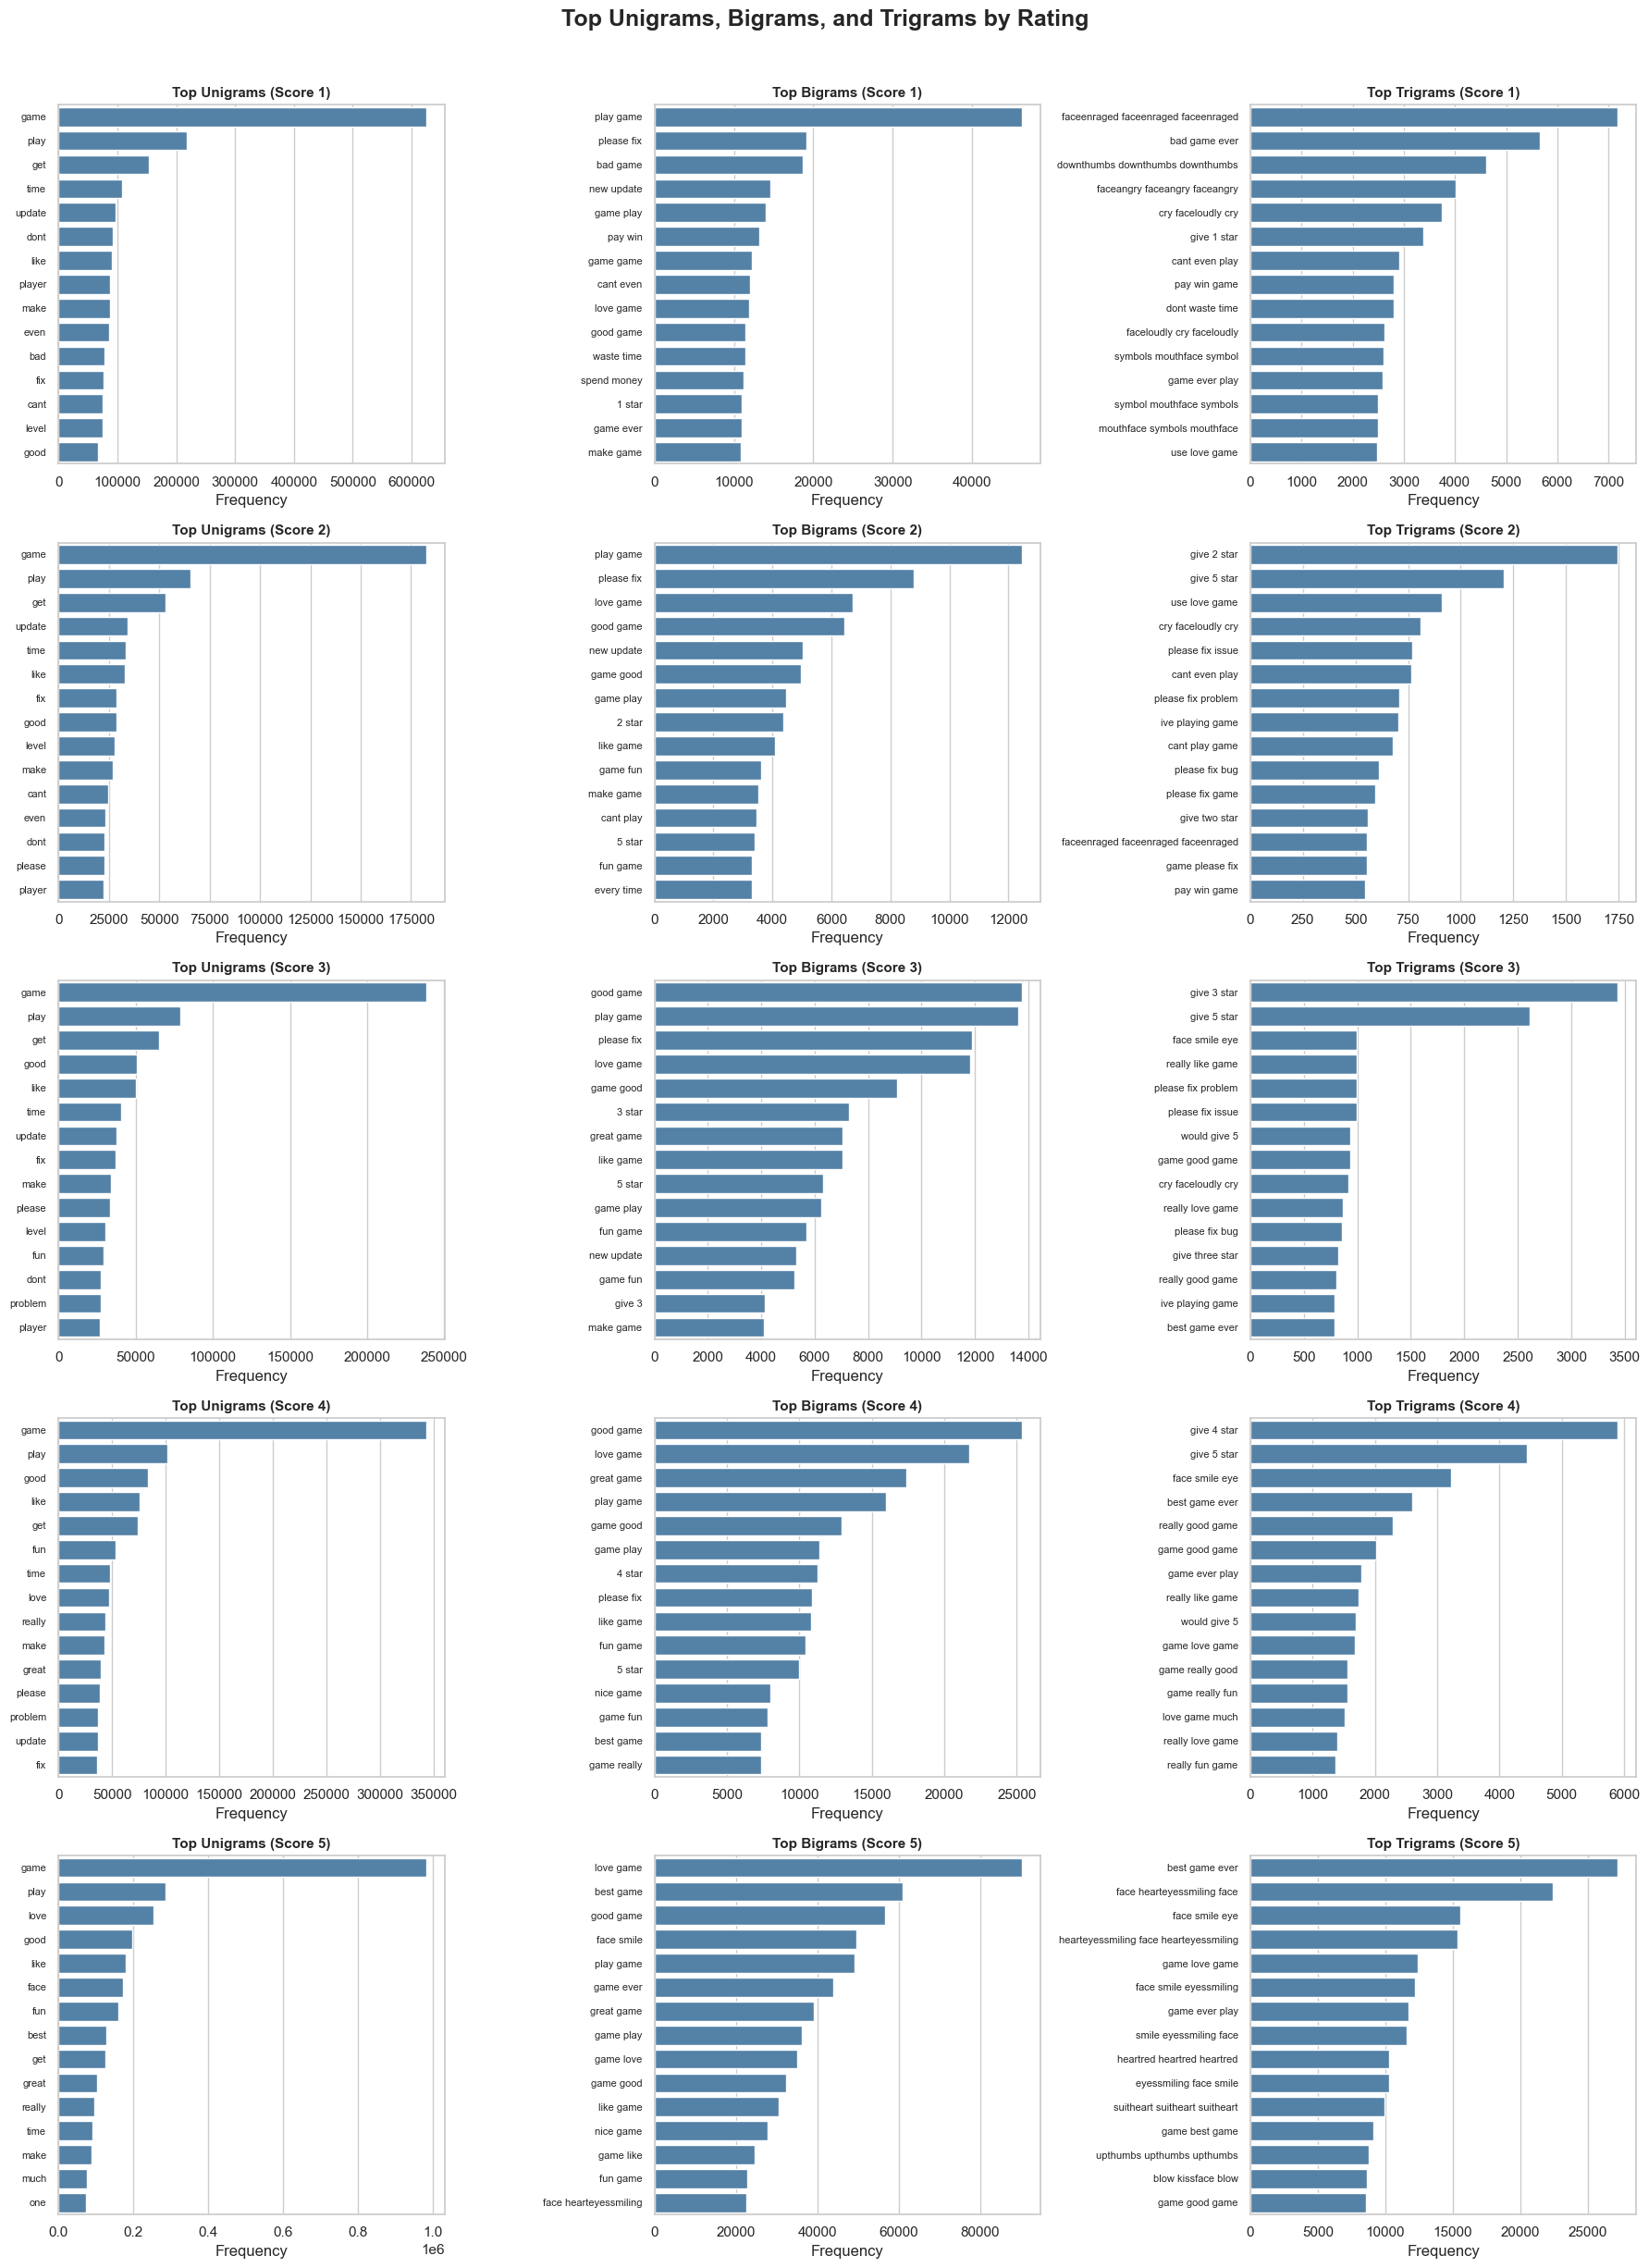

In [15]:
# --- Setup ---
sns.set(style="whitegrid")

# ensure 'score' column is numeric
data["score"] = pd.to_numeric(data["score"], errors="coerce")

# get sorted unique ratings (e.g. [1,2,3,4,5])
ratings = sorted(data["score"].dropna().unique())
n_scores = len(ratings)

# create subplot grid: one row per rating, 3 columns for unigram/bigram/trigram
fig, axes = plt.subplots(n_scores, 3, figsize=(18, 5 * n_scores))
if n_scores == 1:
    axes = [axes]  # handle case with only one rating

# --- Generate n-grams and plots per rating ---
for row, score in enumerate(ratings):
    df_subset = data[data["score"] == score]
    words = " ".join(df_subset["content"].dropna()).split()

    # store results for each n
    ngram_dfs = []

    for n, label in zip([1, 2, 3], ["Unigram", "Bigram", "Trigram"]):
        ngram_counts = Counter(ngrams(words, n))
        top_ngrams = ngram_counts.most_common(15)
        df_ngram = pd.DataFrame(top_ngrams, columns=["ngram", "count"])
        df_ngram["ngram"] = df_ngram["ngram"].apply(lambda x: " ".join(x))
        df_ngram["type"] = label
        ngram_dfs.append(df_ngram)

    ngram_df = pd.concat(ngram_dfs, ignore_index=True)

    # plot each n-gram type in separate column
    for col, label in enumerate(["Unigram", "Bigram", "Trigram"]):
        ax = axes[row][col] if n_scores > 1 else axes[col]
        subset = ngram_df[ngram_df["type"] == label].sort_values("count", ascending=False)

        sns.barplot(y="ngram", x="count", data=subset, ax=ax, color="steelblue")
        ax.set_title(f"Top {label}s (Score {score})", fontsize=11, fontweight="bold")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=8)

plt.suptitle("Top Unigrams, Bigrams, and Trigrams by Rating", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


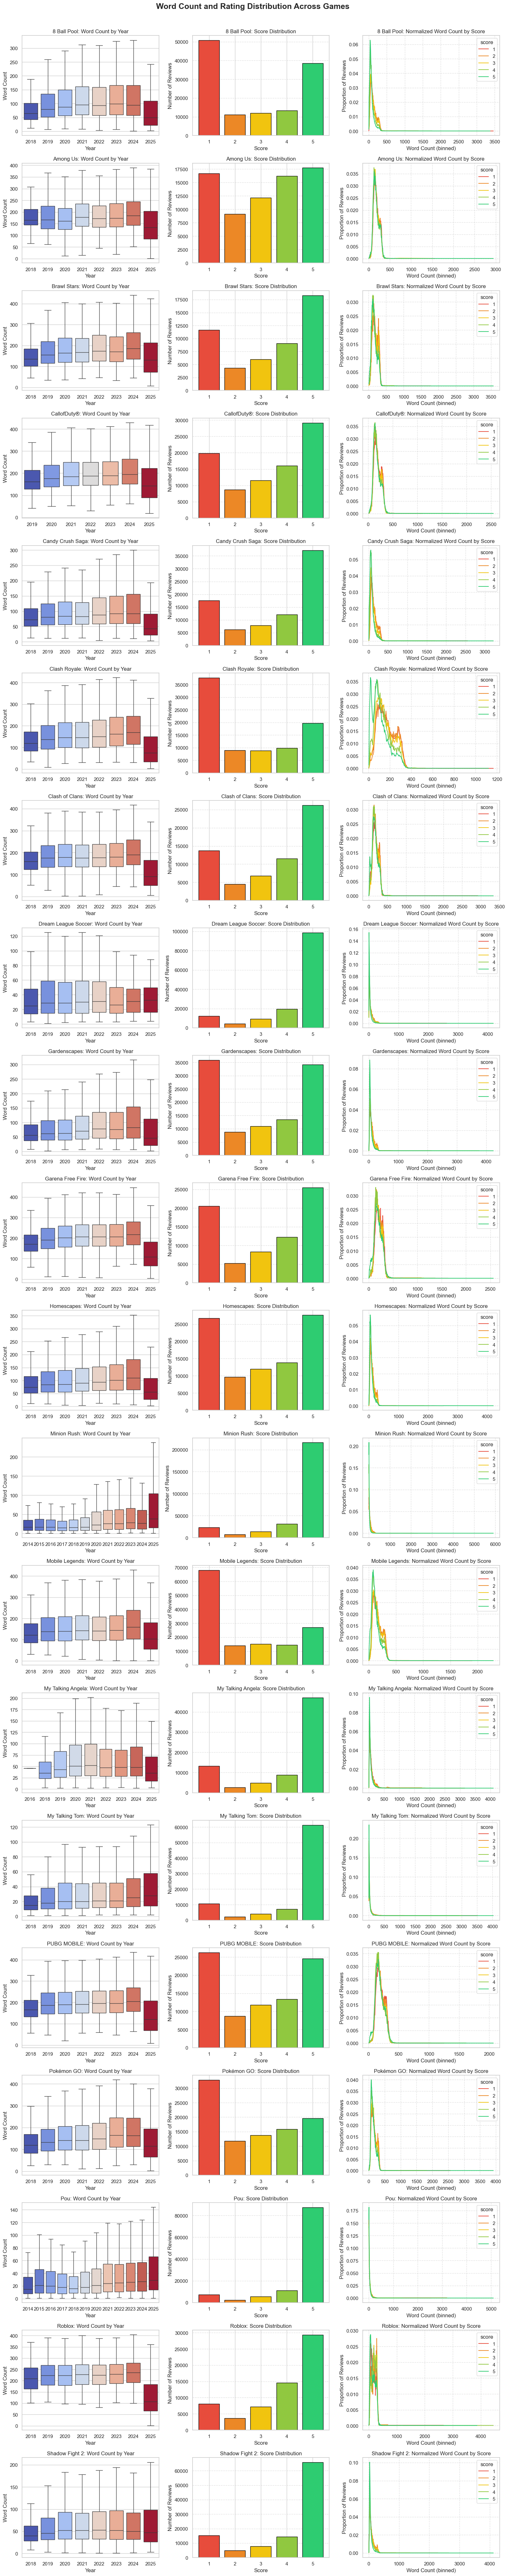

In [16]:
games = sorted(data["game_name"].unique())
fig, axes = plt.subplots(len(games), 3, figsize=(16, 4 * len(games)))

sns.set(style="whitegrid")
rating_colors = LinearSegmentedColormap.from_list("rating_colormap", ["#e74c3c", "#f1c40f", "#2ecc71"], N=5)

for i, app_name in enumerate(games):
    game_data = data[data["game_name"] == app_name].copy()
    if game_data.empty:
        for j in range(3):
            axes[i][j].axis("off")
        continue

    # --- preprocess ---
    game_data["length"] = game_data["content"].astype(str).str.len()
    game_data["word_count"] = game_data["content"].astype(str).str.split().str.len()

    # --- 1️⃣ Word count by year ---
    sns.boxplot(
        x="year", y="length", hue="year",
        data=game_data, palette="coolwarm",
        showfliers=False, legend=False, ax=axes[i][0]
    )
    axes[i][0].set_title(f"{app_name}: Word Count by Year")
    axes[i][0].set_xlabel("Year")
    axes[i][0].set_ylabel("Word Count")

    # --- 2️⃣ Score distribution ---
    score_count = game_data["score"].value_counts().sort_index()
    axes[i][1].bar(
        score_count.index,
        score_count.values,
        color=[rating_colors((s - 1) / 4) for s in score_count.index],
        edgecolor="black"
    )
    axes[i][1].set_title(f"{app_name}: Score Distribution")
    axes[i][1].set_xlabel("Score")
    axes[i][1].set_ylabel("Number of Reviews")
    axes[i][1].grid(axis="y", linestyle="--", alpha=0.6)

    # --- 3️⃣ Normalized word count distribution ---
    bins = np.arange(0, game_data["length"].max() + 5, 5)
    game_data["word_bin"] = pd.cut(game_data["length"], bins)

    word_counts = (
        game_data.groupby(["word_bin", "score"], observed=True)
        .size().reset_index(name="count")
    )
    total_per_score = word_counts.groupby("score")["count"].transform("sum")
    word_counts["normalized"] = word_counts["count"] / total_per_score
    word_counts["word_mid"] = word_counts["word_bin"].apply(lambda x: x.mid)

    sns.lineplot(
        data=word_counts,
        x="word_mid",
        y="normalized",
        hue="score",
        palette=[rating_colors((s - 1) / 4) for s in sorted(word_counts["score"].unique())],
        ax=axes[i][2]
    )
    axes[i][2].set_title(f"{app_name}: Normalized Word Count by Score")
    axes[i][2].set_xlabel("Word Count (binned)")
    axes[i][2].set_ylabel("Proportion of Reviews")
    axes[i][2].grid(True, linestyle="--", alpha=0.6)

# --- layout ---
plt.tight_layout()
plt.suptitle("Word Count and Rating Distribution Across Games", fontsize=18, fontweight="bold", y=1.008)
plt.show()